<a href="https://colab.research.google.com/github/Amritkandel49/person-based-video-segmentation-using-osnet/blob/main/finetune_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Dataset ./Dataset/

In [ ]:
# data.yaml code
'''
path: dataset_yolo
train: images/train
val: images/val

nc: 1
names: ["pedestrian"]
'''

In [ ]:
import xml.etree.ElementTree as ET

def convert_voc_to_yolo(xml_path, img_width, img_height):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    yolo_labels = []

    for obj in root.findall("object"):
        class_name = obj.find("name").text.lower()

        # Only keep pedestrian
        if class_name != "pedestrian":
            continue

        bndbox = obj.find("bndbox")
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)

        # Convert to YOLO format
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        # class_id = 0 (single class)
        yolo_labels.append(f"0 {x_center} {y_center} {width} {height}")

    return yolo_labels


In [ ]:
!pip install opencv-python
import os
import cv2

import shutil

os.chdir('/content/')

SRC_TRAIN = "./Dataset/train"
SRC_VAL = "./Dataset/valid"
DST = "dataset_yolo"

for split, src in [("train", SRC_TRAIN), ("val", SRC_VAL)]:
    os.makedirs(f"{DST}/images/{split}", exist_ok=True)
    os.makedirs(f"{DST}/labels/{split}", exist_ok=True)

    for file in os.listdir(src):
        if not file.endswith(".png"):
            continue

        img_path = os.path.join(src, file)
        xml_path = img_path.replace(".png", ".xml")

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        yolo_labels = convert_voc_to_yolo(xml_path, w, h)

        # Copy image
        shutil.copy(img_path, f"{DST}/images/{split}/{file}")

        # Write label file
        label_file = file.replace(".png", ".txt")
        with open(f"{DST}/labels/{split}/{label_file}", "w") as f:
            f.write("\n".join(yolo_labels))


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.8 MB/s eta 0:00:00


In [ ]:

from ultralytics import YOLO

# Load pretrained YOLOv8 nano (fastest)
model = YOLO("yolov8m.pt")

model.train(
    data="pedestrian.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    # device="cpu", # Changed 'device=0' to 'device="cpu"' as no GPU is available.
    workers=4,
    single_cls=True,
    augment=True,
    patience=10,
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pedestrian.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretraine

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c87e94684d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

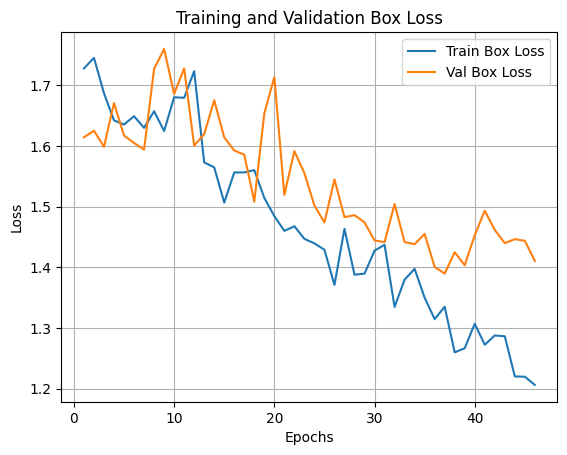

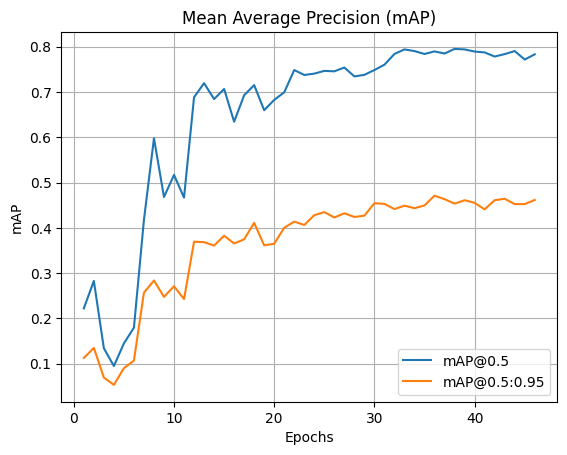

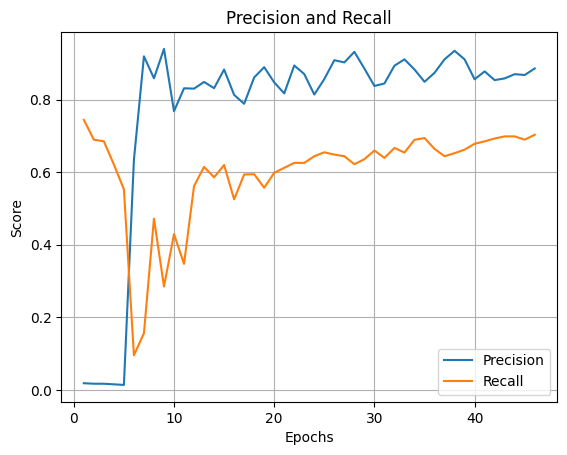

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/runs/detect/train2/results.csv")
epochs = df["epoch"]

# ---- BOX LOSS ----
plt.figure()
plt.plot(epochs, df["train/box_loss"], label="Train Box Loss")
plt.plot(epochs, df["val/box_loss"], label="Val Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Box Loss")
plt.legend()
plt.grid(True)
plt.savefig("box_loss.png", dpi=300)
plt.show()

# ---- mAP CURVE ----
plt.figure()
plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Mean Average Precision (mAP)")
plt.legend()
plt.grid(True)
plt.savefig("map_curve.png", dpi=300)
plt.show()

# ---- PRECISION & RECALL ----
plt.figure()
plt.plot(epochs, df["metrics/precision(B)"], label="Precision")
plt.plot(epochs, df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision and Recall")
plt.legend()
plt.grid(True)
plt.savefig("precision_recall.png", dpi=300)
plt.show()
